In [1]:
from src.util import read_gpu_results
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
daic_results = read_gpu_results(from_parquet=False)
daic_results.head()

,dataset,speedup,operator,num_cores,selectivity,cardinality_T,cardinality_S,join,GPU,dataset_type,...,nnz_S,r_T,c_T,sparsity_T,sparsity_S,morpheusfi_p,morpheusfi_q,morpheusfi_eis,morpheusfi_ns,morpheusfi_nis
0,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.247709,Linear Regression,-1,1.05385,100000,105385,preset,2080,synthetic,...,"[100000, 53850]",100000,11,0.0,"[0.0, 0.0]",2,0,[0.0],100000,[5385]
1,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.258619,Linear Regression,-1,1.05385,100000,105385,preset,1080,synthetic,...,"[100000, 53850]",100000,11,0.0,"[0.0, 0.0]",2,0,[0.0],100000,[5385]
2,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.323960,Linear Regression,-1,1.05385,100000,105385,preset,a40,synthetic,...,"[100000, 53850]",100000,11,0.0,"[0.0, 0.0]",2,0,[0.0],100000,[5385]
3,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.417618,Linear Regression,-1,1.05385,100000,105385,preset,p100,synthetic,...,"[100000, 53850]",100000,11,0.0,"[0.0, 0.0]",2,0,[0.0],100000,[5385]
4,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.230622,Linear Regression,-1,1.05385,100000,105385,preset,v100,synthetic,...,"[100000, 53850]",100000,11,0.0,"[0.0, 0.0]",2,0,[0.0],100000,[5385]


In [16]:
# Add GPU params
gpu_characteristics = {
    "2080": {
        "memory_bandwidth": 448,
        "cores": 2944,
        "clock_speed": 1515,
    },
    "1080": {
        "memory_bandwidth": 320.3,
        "cores": 2560,
        "clock_speed": 1607,
    },
    "a40": {
        "memory_bandwidth": 696,
        "cores": 10752,
        "clock_speed": 1305,
    },
    "p100": {
        "memory_bandwidth": 732.2,
        "cores": 3584,
        "clock_speed": 1190,
    },
    "v100": {
        "memory_bandwidth": 897.0,
        "cores": 5120,
        "clock_speed": 1230,
    },
}
gpu_chars = pd.DataFrame(gpu_characteristics).T.rename({x: f"gpu_{x}" for x in gpu_characteristics["2080"].keys()}, axis=1)
daic_results = daic_results.merge(gpu_chars, left_on="GPU", right_index=True)

In [17]:
def train_test_validate_split(df, test_fraction=0.3):
    validate = df[(df['GPU'] == 'p100') | (df['dataset_type'] != 'synthetic')]
    train, test = train_test_split(df[~df.index.isin(validate.index)], test_size=test_fraction)
    return train, test, validate

In [18]:
train, test, validate = train_test_validate_split(daic_results)

def describe(df, name):
    print(f"{name} set:")
    print(f"\tRecords: {len(df)}")
    pos, neg = len(df[df.speedup > 1]), len(df[df.speedup <= 1])
    print(f"\tPositive (speedup > 1 with factorizing)/Negative: {pos}/{neg} = {pos/neg:.2f} s")
    print(f"\tDataset types: {df.dataset_type.unique()}")
    print(f"\tGPUs: {df.GPU.unique()}")

describe(train, 'train')
describe(test, 'train')
describe(validate, 'validate')


train set:
	Records: 27042
	Positive (speedup > 1 with factorizing)/Negative: 1151/25814 = 0.04 s
	Dataset types: ['synthetic']
	GPUs: ['2080' 'a40' 'v100' '1080']
train set:
	Records: 11590
	Positive (speedup > 1 with factorizing)/Negative: 509/11052 = 0.05 s
	Dataset types: ['synthetic']
	GPUs: ['a40' '1080' '2080' 'v100']
train set:
	Records: 10080
	Positive (speedup > 1 with factorizing)/Negative: 841/9239 = 0.09 s
	Dataset types: ['hamlet' 'synthetic']
	GPUs: ['2080' '1080' 'a40' 'p100' 'v100']


In [7]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import src.estimators
from src.estimators import eval_model
import importlib


def feature_transform_pipe(model, X_train):
    categorical_features = ["operator"]
    for feature in {"num_cores", "GPU"}.intersection(X_train.columns):
        categorical_features.append(feature)
    print(categorical_features)

    numeric_features = [x for x in X_train.columns if x not in categorical_features]
    transformers = [("num", StandardScaler(), numeric_features), ("cat", OneHotEncoder(), categorical_features)]

    preprocessor = ColumnTransformer(transformers=transformers)
    pipe = make_pipeline(preprocessor, model)
    return pipe


def train_and_score(model, X_train, X_test, y_train, y_test):
    pipe = feature_transform_pipe(model=model, X_train=X_train)
    pipe.fit(X_train, y_train)
    eval_model(pipe, X_test, y_test)
    return pipe

In [8]:
train.columns

Index(['dataset', 'speedup', 'operator', 'num_cores', 'selectivity',
       'cardinality_T', 'cardinality_S', 'join', 'GPU', 'dataset_type',
       'label', 'features', 'parallelism', 'mem_mat_read', 'mem_mat_write',
       'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat',
       'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac',
       'comp_mat_col_major', 'comp_fac_col_major', 'comp_scalar_dense', '13',
       '14', 'comp_matrix_dense', 'mem_read_scalar_dense',
       'mem_write_scalar_dense', 'mem_read_matrix_dense',
       'mem_write_matrix_dense', 'mem_read_rowsum', 'mem_write_rowsum',
       'mem_read_colsum', 'mem_write_colsum', '24', '25', 'comp_rowsum',
       'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio', 'tr', 'fr', 'r_S',
       'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S', 'r_T', 'c_T',
       'sparsity_T', 'sparsity_S', 'morpheusfi_p', 'morpheusfi_q',
       'morpheusfi_eis', 'morpheusfi_ns', 'morpheusfi_nis',
       'gpu_memor

In [9]:
model_features = [
    "cardinality_S",
    "cardinality_T",
    "comp_lmm_fac",
    "comp_lmm_mat",
    "comp_ratio",
    "comp_scalar_dense",
    "fr",
    # "GPU",
    "mem_write_rowsum",
    "nnz_S_sum", "nnz_T",
    "operator",
    "r_T", "c_T",
    # "r_S", "c_S",
    "selectivity",
    "sparsity_T",
    "tr",
    'gpu_memory_bandwidth',
    'gpu_cores', 
    'gpu_clock_speed'
]
X_train, y_train = train[model_features], train["label"]
X_test, y_test = test[model_features], test["label"]

In [10]:
log_reg = train_and_score(LogisticRegression(max_iter=250, class_weight='balanced'), X_train, X_test, y_train, y_test)

['operator']


Model <class 'sklearn.pipeline.Pipeline'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV

classes_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)

cv_params = {
    "xgbclassifier__reg_alpha": [0.05, 0.1, 1, 2, 3],
    "xgbclassifier__reg_lambda": [0.05, 0.1, 1, 2, 3],
}  # {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}#{'max_depth':[3,4,5,6,7,8,9,10],'min_child_weight':[1,2,3,4,5,6,7,8,9,10],'gamma':[0,0.1,0.2,0.3,0.4,0.5]} #{'n_estimators':[50,100,200,400,500],'learning_rate':[0.01,0.05,0.1,0.2,0.3]}#
other_params = {
    "learning_rate": 0.2,
    "n_estimators": 400,
    "max_depth": 8,
    "min_child_weight": 1,
    "seed": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.8,
    "gamma": 0.2,
    # "reg_alpha": 1,
    # "reg_lambda": 0.1,
}
xgb_model = feature_transform_pipe(xgb.XGBClassifier(), X_train)
optimized = GridSearchCV(estimator=xgb_model, param_grid=cv_params, scoring="roc_auc", cv=3, verbose=2, n_jobs=8)
optimized.fit(X_train, y_train,xgbclassifier__sample_weight=classes_weights)

['operator']
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.05; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.05; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.05; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.1; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=1; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=2; total time=   0.4s
[CV] END xgbclassifier__reg_alp

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['cardinality_S',
                                                                          'cardinality_T',
                                                                          'comp_lmm_fac',
                                                                          'comp_lmm_mat',
                                                                          'comp_ratio',
                                                                          'comp_scalar_dense',
                                                                          'fr',
                                                                          'mem_write_rowsum',
                                                                          'nnz_S_sum',
                                                                          'nnz_T',
                                                                          'r_T',
                                                                          'c_T',
                                                                          'selectivity',
                                                                          'sparsity_T',
                                                                          'tr',
                                                                          'gpu_memory_bandwidth',
                                                                          'gpu_cores',
                                                                          'gpu_clock...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=8,
             param_grid={'xgbclassifier__reg_alpha': [0.05, 0.1, 1, 2, 3],
                         'xgbclassifier__reg_lambda': [0.05, 0.1, 1, 2, 3]},
             scoring='roc_auc', verbose=2)

In [12]:
xgb_optimized = optimized
eval_model(optimized, X_test, y_test)

Model <class 'sklearn.model_selection._search.GridSearchCV'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')


({'accuracy': 0.9879206212251941,
  'precision': 0.8044871794871795,
  'recall': 0.9653846153846154,
  'f1': 0.8776223776223777},
 None)

In [13]:
from src.estimators import MorpheusFI, Morpheus, Amalur
import src.estimators
from src.estimators import eval_model
importlib.reload(src.estimators)
result_compare = {}
log_reg.__class__.__name__ = "LogisticRegression"
xgb_optimized.__class__.__name__ = "XGBoost"

def full_eval(X_test, y_test, test):

    for model in [MorpheusFI(), Morpheus(), Amalur(), log_reg, xgb_optimized]:
        if isinstance(model, MorpheusFI):
            result_compare[model.__class__.__name__], _ = eval_model(model, test[[x for x in test.columns if 'morpheusfi' in x]], y_test, speedup=test.speedup)
        else: 
            result_compare[model.__class__.__name__], _ = eval_model(model, X_test, y_test, speedup=test.speedup)

    best_speedup=0
    for model in result_compare.keys():
        speedup = result_compare[model]["speedup"]
        best_speedup = speedup['best_speedup'][1]
        new_dict = {}
        for key, value in speedup.items():
            new_key = key + "_abs"
            if isinstance(value, tuple):
                new_value = value[0]
                new_dict[new_key] = new_value
            new_dict[key] = value[1] if isinstance(value, tuple) else value
        result_compare[model].update(new_dict)
        
    test_result_compare = pd.DataFrame(result_compare).T.drop(columns=['speedup'])
    test_result_compare['model'] = test_result_compare.index
    melted_df = pd.melt(test_result_compare, id_vars='model', var_name='metric', value_name='metric_value')
    
    fig, axs = plt.subplot_mosaic("AAAB",figsize=(14,6))
    
    def plot_metrics(ax, metrics: list):
        print(melted_df.head())
        print(melted_df[melted_df.metric.apply(lambda x: x in metrics)])
        ax.set_axisbelow(True)
        ax.grid(axis='y')
        ax = sns.barplot(data=melted_df[melted_df.metric.apply(lambda x: x in metrics)], x='metric', y='metric_value', hue='model', palette=sns.color_palette('flare'), ax=ax)
        # Add metric values as text on top of every bar
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plot_metrics(axs['A'], ['accuracy', 'precision' , 'recall' , 'f1'])
    plot_metrics(axs['B'], ['tot_realized_speedup'])
    axs['B'].axhline(best_speedup, ls='--', color='red', label='Maximum achievable speedup')
    
    fig.suptitle('Performance metrics')

Model <class 'src.estimators.MorpheusFI'>, test cols: Index(['morpheusfi_p', 'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns',
       'morpheusfi_nis'],
      dtype='object')
Model <class 'src.estimators.Morpheus'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')


Model <class 'src.estimators.Amalur'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')
Model <class 'sklearn.pipeline.Pipeline'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')
Model <class 'sklearn.model_selection._search.GridSearchCV'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'oper

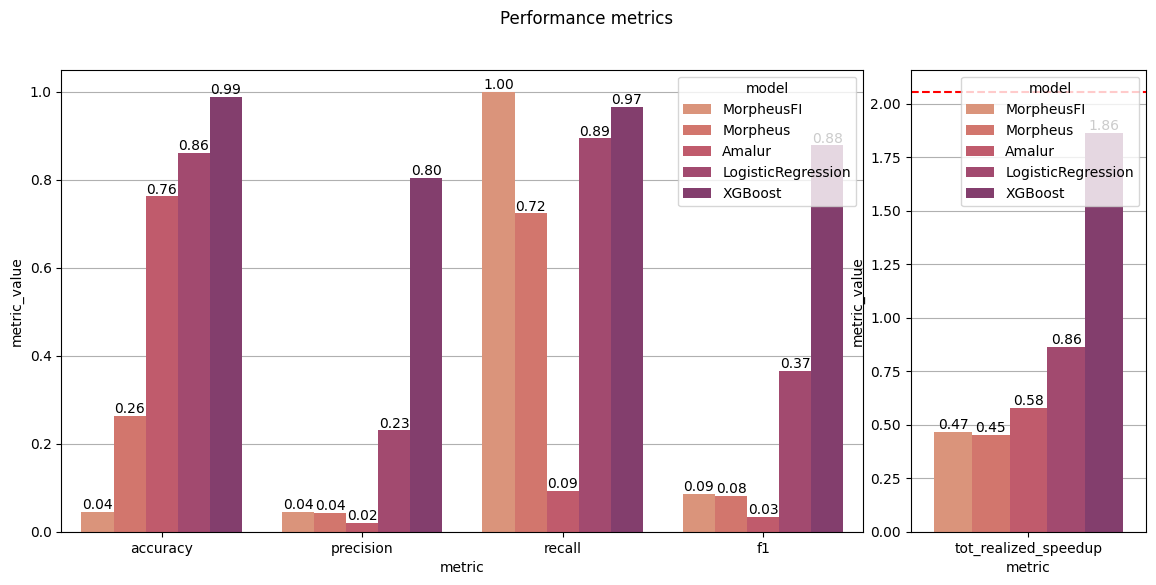

In [14]:
full_eval(X_test, y_test, test)

Model <class 'src.estimators.MorpheusFI'>, test cols: Index(['morpheusfi_p', 'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns',
       'morpheusfi_nis'],
      dtype='object')
Model <class 'src.estimators.Morpheus'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')
Model <class 'src.estimators.Amalur'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')
Model <class 'sklearn.pipeline.Pipeline'>, test cols: Index(['cardinality_

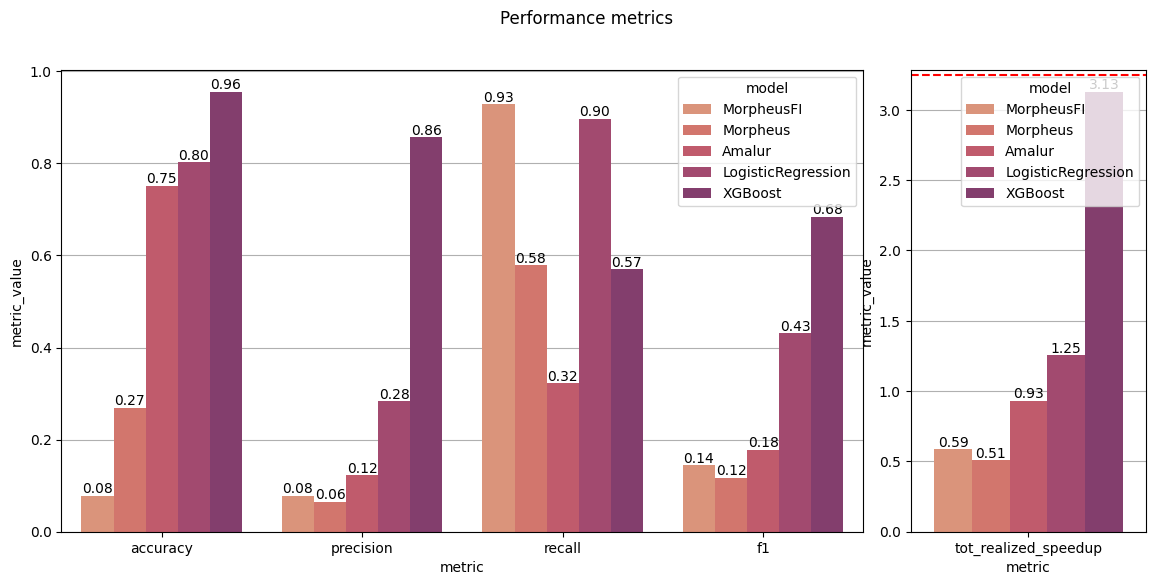

In [15]:
X_validate, y_validate = validate[model_features], validate["label"]
full_eval(X_validate, y_validate, validate)